## Import libraries

In [1]:
import numpy as np # for processing of arrays
import pandas as pd
import sklearn # to display model performance on test set
import statistics
import matplotlib.pyplot as plt # to display images from dataset
import os
from glob import glob
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

# import tensorflow backend and keras api
import tensorflow as tf
import keras
import keras.backend as K

# import model layers and InceptionV3 architecture
from tensorflow.python.keras.models import Model
from sklearn.ensemble import RandomForestClassifier

# import optimizers and callbacks
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

from tensorflow.python.keras.layers import VersionAwareLayers

layers = VersionAwareLayers()
Dropout = layers.Dropout
Dense = layers.Dense
Input = layers.Input
concatenate = layers.concatenate
GlobalAveragePooling2D = layers.GlobalAveragePooling2D
AveragePooling2D = layers.AveragePooling2D
Flatten = layers.Flatten

## Check if CUDA is available
CUDA is a parallel computing platform which can speed up our computations (i.e. train this model much faster!) and can be used on any Nvidia GPU from the G8x series onwards.

If CUDA is unavailable, check that your runtime has been changed to GPU. (Runtime -> Change runtime type -> GPU)

In [2]:
print("GPU:", tf.config.list_physical_devices('GPU'), "\nCUDA Enabled:", tf.test.is_built_with_cuda(), "\nGPU Name:", tf.test.gpu_device_name(), "\nVisible Devices:", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 
CUDA Enabled: True 
GPU Name: /device:GPU:0 
Visible Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12174874738360170017
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10651292948687623576
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Download dataset

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip gdrive/MyDrive/ff.zip

Streaming output truncated to the last 5000 lines.
  inflating: val/fake_image/00044/00619.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00619.jpg  
  inflating: val/fake_image/00044/00180.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00180.jpg  
  inflating: val/fake_image/00044/00154.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00154.jpg  
  inflating: val/fake_image/00044/00800.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00800.jpg  
  inflating: val/fake_image/00044/00206.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00206.jpg  
  inflating: val/fake_image/00044/00826.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00826.jpg  
  inflating: val/fake_image/00044/00749.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00749.jpg  
  inflating: val/fake_image/00044/00774.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00774.jpg  
  inflating: val/fake_image/00044/00413.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00413.jpg  
  inflating: val/fake_

In [9]:
# ImageDataGenerator loads images into memory in batches of specified size (in this case 16 images per batch)
# this avoids possible memory issues
train_folder = 'train'
val_folder = 'val'
df_train = pd.read_csv(train_folder + '/image_labels.csv')
df_val = pd.read_csv(val_folder + '/image_labels.csv')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True, width_shift_range=0.05, height_shift_range=0.05) # rescaling normalizes pixel values from the range [0,255] to [0,1]
train_set = datagen.flow_from_dataframe(dataframe=df_train, directory=train_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=32)
val_set = datagen.flow_from_dataframe(dataframe=df_val, directory=val_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=32)

print("Check class name mapping to label index:")
print(train_set.class_indices)
print(val_set.class_indices)

Found 66722 validated image filenames belonging to 2 classes.
Found 12592 validated image filenames belonging to 2 classes.
Check class name mapping to label index:
{'fake': 0, 'real': 1}
{'fake': 0, 'real': 1}


Loading ResNet50

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [15]:
base_model = InceptionV3(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)))
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'mixed10')>

In [17]:
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)))
# add global pooling and dense layers to obtain output from the model
layer = base_model
layer = GlobalAveragePooling2D()(layer.output)
layer = Dense(2, activation='softmax', name='output')(layer)
input_layer = base_model.input
model = Model(inputs=input_layer, outputs=layer, name="ResNet50")

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# display model summary
model.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________________

<a name="Optimisers"></a>
### Optimiser
> Updates model in response to output of loss function (loss function tells the model the error in classification of individual samples)

In [20]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
# optimisers from Keras https://keras.io/api/optimizers/#available-optimizers
#sgd = SGD(lr=0.001, momentum=0.9, nesterov=False)
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False)

#compile model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

See if you can spot an inception module in the diagram below!

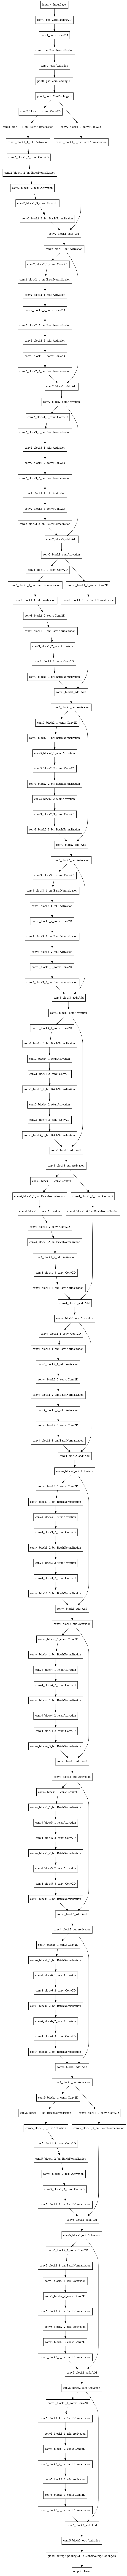

In [23]:
plot_model(model, to_file='model.png')

## Define callbacks

In [25]:
!mkdir "weights"

In [26]:
# ModelCheckpoint callback saves the model weights after every epoch (iteration through the dataset)
# if the validation accuracy is higher than that of the model previously saved
checkpoint = ModelCheckpoint("weights/resnet50.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## Train model
> Fit the model to the data

In [27]:
hist = model.fit(train_set, steps_per_epoch=64, epochs = 50, validation_data=val_set, validation_steps=16, callbacks = [checkpoint])

Epoch 1/50
64/64 [==============================] - 95s 866ms/step - loss: 0.6807 - accuracy: 0.7690 - val_loss: 50.9106 - val_accuracy: 0.1953

Epoch 00001: val_loss improved from inf to 50.91064, saving model to weights/resnet50.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
64/64 [==============================] - 55s 852ms/step - loss: 0.5071 - accuracy: 0.7964 - val_loss: 1.4305 - val_accuracy: 0.7969

Epoch 00002: val_loss improved from 50.91064 to 1.43053, saving model to weights/resnet50.h5
Epoch 3/50
64/64 [==============================] - 55s 850ms/step - loss: 0.4488 - accuracy: 0.8291 - val_loss: 0.4764 - val_accuracy: 0.8184

Epoch 00003: val_loss improved from 1.43053 to 0.47637, saving model to weights/resnet50.h5
Epoch 4/50
64/64 [==============================] - 55s 852ms/step - loss: 0.4537 - accuracy: 0.8052 - val_loss: 0.5306 - val_accuracy: 0.8242

Epoch 00004: val_loss did not improve from 0.47637
Epoch 5/50
64/64 [==============================] - 55s 853ms/step - loss: 0.4441 - accuracy: 0.8257 - val_loss: 0.5580 - val_accuracy: 0.7910

Epoch 00005: val_loss did not improve from 0.47637
Epoch 6/50
64/64 [==============================] - 55s 856ms/step - loss: 0.4546 - accuracy: 0.8076 - val_loss: 0.5491 - val_accuracy: 0

## Display model training/validation accuracy and loss

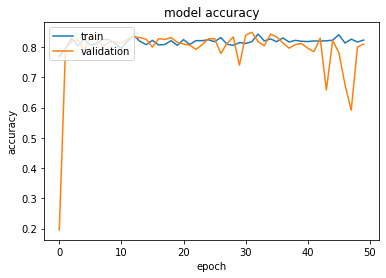

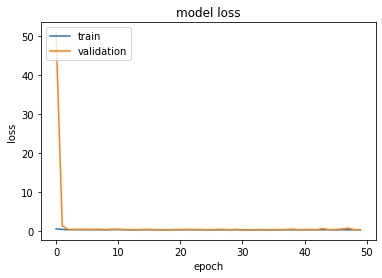

In [28]:
# plot training and validation accuracy against epochs using matplotlib
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss against epochs using matplotlib
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Weights

In [30]:
model.load_weights("weights/resnet50.h5")

<a name="eval"></a>
## Evaluate Model

To classify the video as real or fake, we will first obtain the model's predictions on each frame extracted from the video. We then take the mean of the prediction (probability) of the frames as the prediction of the video. 

In [31]:
def read_image_from_disk(path):

  """
  Helper function to read image from disk given a absolute path.

  :param path: Absolute path to image file on disk
  :return: Image in Numpy Ndarray representation
  """

  img = tf.keras.preprocessing.image.load_img(path, target_size=(299,299,3))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img/255
  img = np.expand_dims(img, axis=0)

  return img


def get_frames_to_vid_mapping(frame_list):

  """
  Helper function to generate a mapping of frames to it's corresponding video 
  name.

  The path of frames in the frame_list will be in such format:
  image/[video name]/[frame number].jpg
  e.g. image/00000/00032.jpg

  :param frame_list: A list of paths to the image frames
  :return: A sorted dictionary with keys as the video name and value as the
           corresponding frames.
           e.g. of returned mapping dictionary:

            {
              "00000":[
                  "00032",
                  "00064",
                  .
                  .
                  .
                  "00487"
              ],
              "00001":[
                  "00000",
                  "00032",
                  .
                  .
                  .
                  "00392"
              ],
              .
              .
              .
              "00790":[
                  "00000",
                  "00027",
                  .
                  .
                  .
                  "00542"
              ]
            }
  """

  # Get all videos name
  vidnames = [frame.split("/")[1:2][0] for frame in frame_list]
  # Get only unique names
  vidnames = set(vidnames)
  # Init the mapping dict
  mapping = {vidname: [] for vidname in vidnames}

  # Add frames to to its corresponding list
  for frame in frame_list:
    vidname = str(frame.split("/")[1:2][0])
    frame_number = str(frame.split("/")[-1].split(".")[0])
    mapping[vidname].append(frame_number)

  return dict(sorted(mapping.items()))


def infer_videos(test_data_path, csv_file, num_of_videos='All'):

  """
  Function to infer a test data set. The function takes in a path to the test
  data set and a csv file that contain the paths of the frames extracted from 
  the videos in the test dataset.

  :param test_data_path: Absoulute path to the test dataset
  :param csv_file: File Name of the CSV file that must be in the test_data_path
  :param num_of_videos: Number of videos to infer from the dataset (default: All)
  :return: Pandas dataframe which contains the prediction (probability of being 
           fake) of each video. 
  """

  list_dir = list(pd.read_csv(test_data_path + csv_file).iloc[:,0])

  mapping = get_frames_to_vid_mapping(list_dir)

  # [*mapping] gives the list of keys (video name) in the mapping dict
  num_of_videos_avail = len([*mapping])

  # Set number of videos to be inferred to total of videos available if given 
  # num_of_videos is more than max amount of available videos
  if num_of_videos == 'All' or num_of_videos > num_of_videos_avail:
      num_of_videos = num_of_videos_avail

  # init mapping of videos to its corresponding predicted probabilities
  videos_to_prediction = {}

  # Loop through each video and make a prediction of each frame in the video.
  # Assigned a prediction to each video by taking the mean of its corresponding
  # frames' probabilities.
  for video_name in [*mapping][0:num_of_videos]:

    frames = mapping[video_name]
    predictions = []
    print("Infering video {video}...".format(video=video_name))
    print("Processing frame ", end=" ")

    # Process each frame in video
    for frame in frames:
      print(frame, end =", ")
      frame_path = "image/{video_name}/{frame}.jpg".format(video_name=video_name, frame=frame)
      img = read_image_from_disk(test_data_path + frame_path)
      prediction = model.predict(img)[0]
      # Collect only the 'real' side of probability
      predictions.append(prediction[1])

    # Take the mean of the probabilities from the frames
    videos_to_prediction[video_name] = statistics.median(predictions)
    print("Done!")
  
  return pd.DataFrame(videos_to_prediction.items())


In [35]:
modelPredictions = infer_videos("test/", "image_labels.csv")
print(modelPredictions)

Infering video 00000...
Processing frame  00032, 00064, 00097, 00129, 00162, 00194, 00227, 00259, 00292, 00324, 00357, 00389, 00422, 00454, 00487, Done!
Infering video 00001...
Processing frame  00000, 00032, 00065, 00098, 00130, 00163, 00196, 00228, 00261, 00294, 00326, 00359, 00392, Done!
Infering video 00002...
Processing frame  00000, 00027, 00054, 00081, 00108, 00135, 00162, 00189, 00216, 00243, 00271, 00298, 00325, 00352, 00379, 00406, 00433, 00460, 00487, 00514, 00542, Done!
Infering video 00003...
Processing frame  00000, 00031, 00063, 00095, 00127, 00159, 00191, 00222, 00254, 00286, 00318, 00350, 00382, 00413, 00445, 00477, 00509, 00541, 00573, 00605, Done!
Infering video 00004...
Processing frame  00000, 00026, 00052, 00078, 00105, 00131, 00157, 00183, 00210, 00236, 00262, 00289, 00315, 00341, 00367, 00394, 00420, 00446, 00472, 00499, 00525, 00551, 00578, 00604, 00630, 00656, 00683, 00709, 00735, 00762, Done!
Infering video 00005...
Processing frame  00000, 00025, 00051, 0007

## Submission

In [36]:
modelPredictions.columns = ['vid_name', 'label']
modelPredictions.to_csv("model_predictions_test.csv", index=False)